In [11]:
!pip install datasets

In [12]:
!pip install preprocessor

In [13]:
!pip install transformers datasets evaluate
!pip install tweet-preprocessor

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# import all necessary libraries

import os
from pathlib import Path

import numpy as np
import nltk
import pandas as pd
from datasets import Dataset, load_metric
from datasets import Dataset, load_metric, load_dataset

from datasets.load import load_dataset
from transformers import AutoTokenizer
import preprocessor as p
from transformers import TrainingArguments, Trainer

from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
data_path = "/content/drive/MyDrive/CrisisNLP_labeled_data_crowdflower/CrisisNLP_labeled_data_crowdflower/2014_Pakistan_floods/2014_Pakistan_floods_CF_labeled_data.tsv"

In [17]:
def fetch_data_from_csv(path):
  df = pd.read_table(path)
  df = pd.DataFrame(df)
  return df

In [18]:
def convertDFtoDataSet(df):
  ds = Dataset.from_pandas(df)
  return ds

In [19]:
data = fetch_data_from_csv(data_path)

In [20]:
def reduceClasses(classVal):
  if classVal == 'other_useful_information' or classVal == 'caution_and_advice' or classVal == 'sympathy_and_emotional_support' or classVal == 'not_related_or_irrelevant':
    return 'not_related_or_irrelevant'
  elif classVal == 'injured_or_dead_people' or classVal == 'missing_trapped_or_found_people' or classVal == 'infrastructure_and_utilities_damage':
    return 'emergency_services_required'
  else:
    return 'donation_needs_or_offers_or_volunteering_services'


In [21]:
data['label'] = data['label'].apply(lambda lab: reduceClasses(lab))

In [22]:
def understandData(df):
  print('--------------------------------Shape of the data is--------------------------')
  print(data.shape)

  print('----------------------the data contains following fields----------------------')
  print(data.columns)

  print('---------------------------------Data Description-----------------------------')
  print(data.describe)

  print('---------------------------------label count----------------------------------')
  print(data['label'].value_counts())

In [23]:
understandData(data)

--------------------------------Shape of the data is--------------------------
(1769, 3)
----------------------the data contains following fields----------------------
Index(['tweet_id', 'tweet_text', 'label'], dtype='object')
---------------------------------Data Description-----------------------------
<bound method NDFrame.describe of                   tweet_id                                         tweet_text  \
0     '509390880315166720'  RT @rehman_azhar: #Sialkot airport where Imran...   
1     '510365408440762368'  Kashmir floods: Hyderpora mosque a symbol of c...   
2     '510662605422096384'  Kashmir Floods: All Party Meeting in Srinagar ...   
3     '509274576275009536'  #NewsUpdates Death Toll from India-Pakistan Fl...   
4     '509392343129022464'  RT @allaboutmqm: Video: Mian Ateeq visit KKF f...   
...                    ...                                                ...   
1764  '511637412385021952'  RT @KlasraRauf: Pungovt claims CMSS took 9 hel...   
1765  '51114

In [24]:
id2label = {0: 'not_related_or_irrelevant', 1: 'emergency_services_required', 2: 'donation_needs_or_offers_or_volunteering_services'}
label2id = {'not_related_or_irrelevant': 0, 'emergency_services_required': 1, 'donation_needs_or_offers_or_volunteering_services': 2}

In [25]:
def exploratoryAnalysis(df):

  plt.figure(figsize=(8,6))
  sns.set_style(style='darkgrid')
  ax = sns.countplot(x = 'label', data = df)
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
  plt.tight_layout()
  plt.title('Class Distribution')
  plt.show()

  plt.figure(figsize=(6,8))
  sns.set_style("darkgrid")
  df['label'].value_counts().plot.pie(autopct='%0.2f%%')
  plt.title("Percentage Contribution")
  plt.xlabel("percent contribution")
  plt.ylabel("label")
  plt.show()

<ipython-input-25-3016a05a294f>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


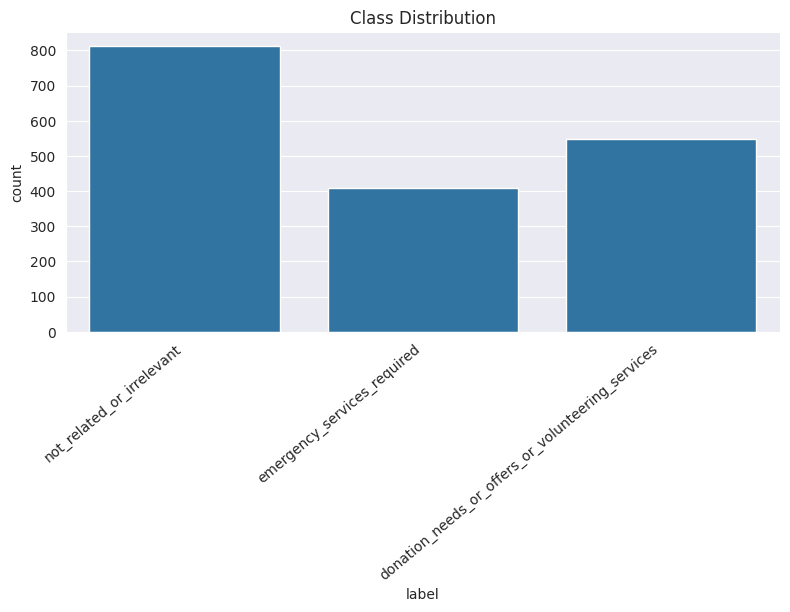

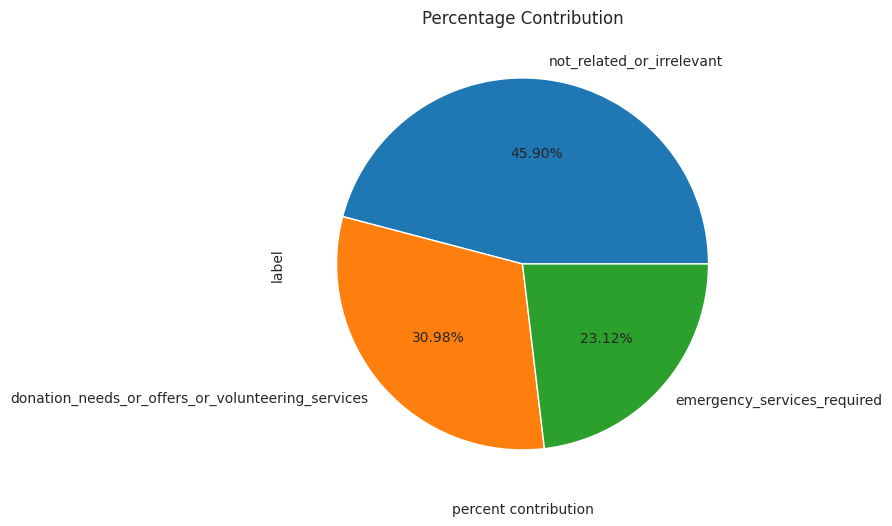

In [26]:
exploratoryAnalysis(data)

In [27]:
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps=PorterStemmer()
stopwords=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [28]:
def cleaner(text):

    cleaned = p.clean(text)
    cleaned=cleaned.replace("//"," ").replace("."," ")
    cleaned=re.sub(r'[^a-zA-Z]'," ",cleaned)
    cleaned=cleaned.strip() #removing whitespace
    cleaned=cleaned.lower() #converting into lower case words
    cleaned=re.sub(r'\w+\d+'," ",cleaned)#remove alphanumeric words
    cleaned=ps.stem(cleaned) #stemming
    cleaned=[word for word in cleaned.split() if len(word)>2]
    cleaned=" ".join(cleaned)
    return cleaned

In [29]:
#cleaning data
data['tweet_text'] = data['tweet_text'].apply(lambda text:cleaner(text))

In [30]:
#converting label to id
def labeltoId(label):
  return label2id[label]

data['label'] = data['label'].apply(lambda label: labeltoId(label))

In [31]:
dataset_data = convertDFtoDataSet(data)

In [32]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
#tokenizer = AutoTokenizer.from_pretrained("distilbert-base-cased")
#tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
def tokenize_data(dataset_data):
    return tokenizer(dataset_data["tweet_text"], padding='max_length')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [33]:
tokenized_data = dataset_data.map(tokenize_data, batched = True)

Map:   0%|          | 0/1769 [00:00<?, ? examples/s]

In [34]:
tokenized_data = tokenized_data.train_test_split(test_size=0.1)
train_d = tokenized_data['train'].shuffle(seed=10)
eval_d = tokenized_data['test'].shuffle(seed=10)

In [35]:
metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)


<ipython-input-35-c203b637589b>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [36]:
!pip install transformers[torch]

In [37]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)


training_args = TrainingArguments(
    "test_trainer",
    num_train_epochs=10,
    learning_rate=0.001,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    #weight_decay=0.01
    )
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_d,
    eval_dataset=eval_d,
    compute_metrics=compute_metrics
)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
# Train the model
trainer.train()

Step,Training Loss
500,1.116800


Step,Training Loss
500,1.116800
1000,1.090000


TrainOutput(global_step=1000, training_loss=1.1033975219726562, metrics={'train_runtime': 1489.3379, 'train_samples_per_second': 10.689, 'train_steps_per_second': 0.671, 'total_flos': 4188765610229760.0, 'train_loss': 1.1033975219726562, 'epoch': 10.0})

In [39]:
# Get the training logs
train_logs = trainer.state.log_history

In [40]:
for i, log in enumerate(train_logs):
    print(f"Epoch {i+1}/{len(train_logs)}")
    if 'loss' in log and 'accuracy' in log:
        print(f"  - loss: {log['loss']:.4f} - accuracy: {log['accuracy']:.4f}")
    if 'eval_loss' in log and 'eval_accuracy' in log:
        print(f"  - val_loss: {log['eval_loss']:.4f} - val_accuracy: {log['eval_accuracy']:.4f}")

Epoch 1/3
Epoch 2/3
Epoch 3/3


In [41]:
# Evaluate the model
eval_results = trainer.evaluate()

In [42]:
# Print the evaluation metrics
print("Evaluation results:")
print(f"  - loss: {eval_results['eval_loss']:.4f} - accuracy: {eval_results['eval_accuracy']:.4f}")

Evaluation results:
  - loss: 1.0701 - accuracy: 0.4633


In [43]:
# Save the trained model
model_path = "./saved_model"
trainer.save_model(model_path)

In [44]:
# Get predictions on the test dataset
test_predictions = trainer.predict(eval_d)
test_logits = test_predictions.predictions
test_labels = eval_d["label"]
# Compute predicted class indices
print(test_logits)
predicted_class_indices = np.argmax(test_logits, axis=-1)
print(predicted_class_indices)

[[-0.09508774 -0.93476796 -0.41558537]
 [-0.09508774 -0.93476796 -0.4155854 ]
 [-0.09508774 -0.93476796 -0.4155854 ]
 [-0.09508774 -0.93476796 -0.4155854 ]
 [-0.09508774 -0.93476796 -0.4155854 ]
 [-0.09508774 -0.934768   -0.41558537]
 [-0.09508774 -0.93476796 -0.4155854 ]
 [-0.09508774 -0.9347679  -0.4155854 ]
 [-0.09508774 -0.9347679  -0.4155854 ]
 [-0.09508771 -0.9347679  -0.4155854 ]
 [-0.09508774 -0.934768   -0.4155854 ]
 [-0.09508774 -0.93476796 -0.41558537]
 [-0.09508774 -0.93476796 -0.41558537]
 [-0.09508774 -0.93476796 -0.4155854 ]
 [-0.09508774 -0.93476796 -0.4155854 ]
 [-0.09508771 -0.93476796 -0.4155854 ]
 [-0.09508774 -0.93476796 -0.4155854 ]
 [-0.09508774 -0.93476796 -0.4155854 ]
 [-0.09508774 -0.93476796 -0.41558537]
 [-0.09508774 -0.93476796 -0.41558537]
 [-0.09508774 -0.93476796 -0.4155854 ]
 [-0.09508774 -0.93476796 -0.4155854 ]
 [-0.09508774 -0.93476796 -0.4155854 ]
 [-0.09508774 -0.934768   -0.41558537]
 [-0.09508774 -0.934768   -0.4155854 ]
 [-0.09508774 -0.9347679 

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
# Compute confusion matrix
confusion_mat = confusion_matrix(test_labels, predicted_class_indices)

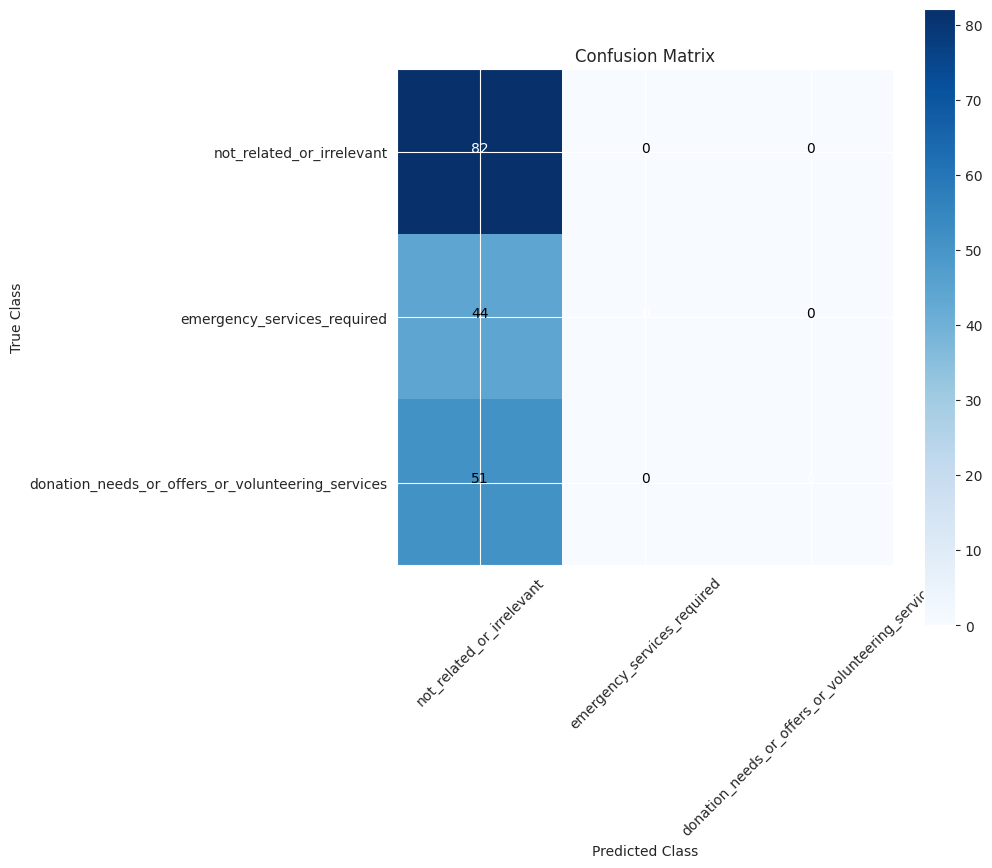

In [46]:
# Visualize confusion matrix with numbers
class_names = ['not_related_or_irrelevant', 'emergency_services_required', 'donation_needs_or_offers_or_volunteering_services']


plt.figure(figsize=(8, 8))
plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)

# Add numbers to the confusion matrix
for i in range(confusion_mat.shape[0]):
    for j in range(confusion_mat.shape[1]):
        plt.text(j, i, str(confusion_mat[i, j]), horizontalalignment="center", color="white" if i == j else "black")

plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
precision, recall, f1, support = precision_recall_fscore_support(test_labels, predicted_class_indices)

# Print the results
for i in range(len(class_names)):
    print(f"Class {i}:")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1 Score: {f1[i]}")

In [48]:
correct_predictions = np.sum(np.diag(confusion_mat))
total_predictions = np.sum(confusion_mat)
accuracy = correct_predictions / total_predictions
print(accuracy)

0.4632768361581921
0.4632768361581921
